## Quickstart deduplication demo 

In this demo we de-duplicate a small dataset.

The purpose is to demonstrate core Splink functionality as quickly as possible.

A more comprehensive, end to end example is provided elsewhere

## Step 1:  Imports and setup

The following is just boilerplate code that sets up the Spark session and sets some other non-essential configuration options

In [1]:
import pandas as pd 
pd.options.display.max_columns = 500
pd.options.display.max_rows = 100

In [2]:
import logging 
logging.basicConfig()  # Means logs will print in Jupyter Lab

# Set to DEBUG if you want splink to log the SQL statements it's executing under the hood
logging.getLogger("splink").setLevel(logging.INFO)

In [3]:
from utility_functions.demo_utils import get_spark
spark = get_spark() # See utility_functions/demo_utils.py for how to set up Spark

## Step 2:  Read in data

Note that the `group` column is the truth - rows which share the same value refer to the same person.  In the real world, we wouldn't have this field!

In [4]:
df = spark.read.parquet("data/fake_1000.parquet")
df.show(5)

+---------+----------+-------+----------+------+--------------------+-----+
|unique_id|first_name|surname|       dob|  city|               email|group|
+---------+----------+-------+----------+------+--------------------+-----+
|        0|    Julia |   null|2015-10-29|London| hannah88@powers.com|    0|
|        1|    Julia | Taylor|2015-07-31|London| hannah88@powers.com|    0|
|        2|    Julia | Taylor|2016-01-27|London| hannah88@powers.com|    0|
|        3|    Julia | Taylor|2015-10-29|  null|  hannah88opowersc@m|    0|
|        4|      oNah| Watson|2008-03-23|Bolton|matthew78@ballard...|    1|
+---------+----------+-------+----------+------+--------------------+-----+
only showing top 5 rows



## Step 3:  Configure splink using the `settings` object

Most of `splink` configuration options are stored in a settings dictionary.  This dictionary allows significant customisation, and can therefore get quite complex.  

💥 We provide an tool for helping to author valid settings dictionaries, which includes tooltips and autocomplete, which you can find [here](http://robinlinacre.com/splink_settings_editor/).

Customisation overrides default values built into splink.  For the purposes of this demo, we will specify a simple settings dictionary, which means we will be relying on these sensible defaults.

To help with authoring and validation of the settings dictionary, we have written a [json schema](https://json-schema.org/), which can be found [here](https://github.com/moj-analytical-services/splink/blob/master/splink/files/settings_jsonschema.json).  




In [5]:
settings = {
    "link_type": "dedupe_only",
    "blocking_rules": [
        "l.surname = r.surname"
    ],
    "comparison_columns": [
        {
            "col_name": "first_name",
            "num_levels": 3,
            "term_frequency_adjustments": True
        },
        {
            "col_name": "dob"
        },
        {
            "col_name": "city"
        },
        {
            "col_name": "email"
        }
    ],
    "additional_columns_to_retain": ["group"],
    "em_convergence": 0.01
}

In words, this setting dictionary says:
- We are performing a deduplication task (the other options are `link_only`, or `link_and_dedupe`)
- We are going generate comparisons subject to the blocking rules contained in the specified array
- When comparing records, we will use information from the `first_name`, `surname`, `dob`, `city` and `email` columns to compute a match score.
- For `first_name` and `surname`, string comparisons will have three levels:
    - Level 2: Strings are (almost) exactly the same
    - Level 1: Strings are similar 
    - Level 0: No match
- We will make adjustments for term frequencies on the `first_name` and `surname` columns
- We will retain the `group` column in the results even though this is not used as part of comparisons.  This is a labelled dataset and `group` contains the true match - i.e. where group matches, the records pertain to the same person
- Consider the algorithm to have converged when no parameter changes by more than 0.01 between iterations

## Step 4:  Estimate match scores using the Expectation Maximisation algorithm
Columns are assumed to be strings by default.  See the 'comparison vector settings' notebook for details of configuration options.

In [6]:
from splink import Splink

linker = Splink(settings, df, spark)
df_e = linker.get_scored_comparisons()

INFO:splink.iterate:Iteration 0 complete
INFO:splink.model:The maximum change in parameters was 0.17303137779235844 for key first_name, level 0
INFO:splink.iterate:Iteration 1 complete
INFO:splink.model:The maximum change in parameters was 0.059999048709869385 for key city, level 1
INFO:splink.iterate:Iteration 2 complete
INFO:splink.model:The maximum change in parameters was 0.02698001265525818 for key email, level 0
INFO:splink.iterate:Iteration 3 complete
INFO:splink.model:The maximum change in parameters was 0.020812273025512695 for key email, level 1
INFO:splink.iterate:Iteration 4 complete
INFO:splink.model:The maximum change in parameters was 0.014915108680725098 for key email, level 0
INFO:splink.iterate:Iteration 5 complete
INFO:splink.model:The maximum change in parameters was 0.010272204875946045 for key email, level 0
INFO:splink.iterate:Iteration 6 complete
INFO:splink.model:The maximum change in parameters was 0.007032573223114014 for key email, level 1
INFO:splink.iterat

## Step 5: Inspect results 



In [7]:
# Inspect main dataframe that contains the match scores
cols_to_inspect = ["match_probability","unique_id_l","unique_id_r","group_l", "group_r", "first_name_l","first_name_r","dob_l","dob_r","city_l","city_r","email_l","email_r",]
df_e.toPandas()[cols_to_inspect].sort_values(["unique_id_l", "unique_id_r"]).head(10)
df_e.toPandas()

,tf_adjusted_match_prob,match_probability,unique_id_l,unique_id_r,first_name_l,first_name_r,gamma_first_name,dob_l,dob_r,gamma_dob,city_l,city_r,gamma_city,email_l,email_r,gamma_email,group_l,group_r
0,0.002481,0.002481,1,975,Julia,Reuben,0,2015-07-31,1978-05-09,0,London,Lnndo,0,hannah88@powers.com,tiffanyrodriguez@rodriguez-yu.com,0,0,175
1,0.002481,0.002481,1,974,Julia,Reuben,0,2015-07-31,1978-05-09,0,London,Lonno,0,hannah88@powers.com,tiffanyrodrigueu@rodrigzez-u.com,0,0,175
2,0.016967,0.016967,1,971,Julia,None,-1,2015-07-31,1978-05-09,0,London,Ldnon,0,hannah88@powers.com,tiffanyrodriguez@rodriguez-yu.com,0,0,175
3,0.007975,0.007975,1,751,Julia,Michael,0,2015-07-31,1993-03-29,0,London,Brighton,0,hannah88@powers.com,None,-1,0,129
4,0.002481,0.002481,1,750,Julia,hicMae,0,2015-07-31,1993-06-23,0,London,Brighton,0,hannah88@powers.com,rhondawilliams@gonzalez-scott.com,0,0,129
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3162,0.999944,0.999944,991,992,liL,ily,0,1995-09-05,1995-09-05,1,London,London,1,wesleykidd@miller.com,wesleykidd@miller.com,1,179,179
3163,0.995620,0.995620,992,997,ily,None,-1,1995-09-05,1995-11-03,0,London,London,1,wesleykidd@miller.com,wesleykidd@miller.com,1,179,179
3164,0.202650,0.202650,992,993,ily,None,-1,1995-09-05,1995-11-09,0,London,London,1,wesleykidd@miller.com,weslcykidd@miler.eom,0,179,179
3165,0.202650,0.202650,993,997,None,None,-1,1995-11-09,1995-11-03,0,London,London,1,weslcykidd@miler.eom,wesleykidd@miller.com,0,179,179


The `model` property of the `linker` is an object that contains a lot of diagnostic information about how the match probability was computed.  The following cells demonstrate some of its functionality

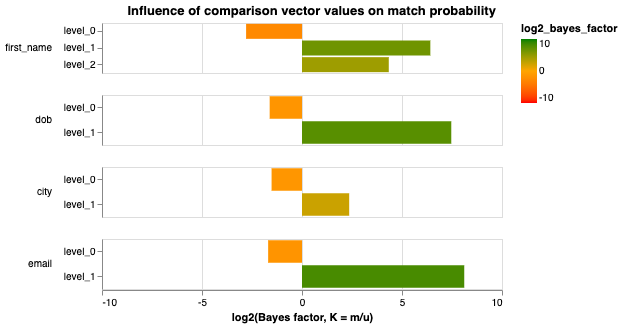

In [8]:
import altair as alt
alt.renderers.enable('mimetype')
model = linker.model
model.bayes_factor_chart()

In [9]:
# If charts aren't displaying correctly in your notebook, you can write them to a file (by default splink_charts.html)
model.all_charts_write_html_file(filename="splink_charts.html", overwrite=True)

You can also generate a report which explains how the match probability was computed for an individual comparison row.  

Note that you need to convert the row to a dictionary for this to work

# Use graphframes to resolve links into groups

In [10]:
from graphframes import GraphFrame


df_e.createOrReplaceTempView("df_e")
sql = """
select unique_id_l as id
from df_e
union
select unique_id_r as id
from df_e
"""
nodes = spark.sql(sql)

sql = """
select
unique_id_l as src,
unique_id_r as dst,
tf_adjusted_match_prob
from df_e
where tf_adjusted_match_prob > 0.99
"""
edges = spark.sql(sql)

g = GraphFrame(nodes, edges)

cc = g.connectedComponents()

cc.createOrReplaceTempView("cc")
df.createOrReplaceTempView("df")
sql = """
select cc.component as estimated_group, df.*
from cc
left join
df 
on cc.id = df.unique_id
order by group, estimated_group
"""
results = spark.sql(sql)
results.toPandas().head(30)

,estimated_group,unique_id,first_name,surname,dob,city,email,group
0,1,2,Julia,Taylor,2016-01-27,London,hannah88@powers.com,0
1,1,1,Julia,Taylor,2015-07-31,London,hannah88@powers.com,0
2,3,3,Julia,Taylor,2015-10-29,None,hannah88opowersc@m,0
3,4,7,Noah,Watson,2008-02-05,tolon,matthew78@ballard-mcdonald.net,1
4,4,4,oNah,Watson,2008-03-23,Bolton,matthew78@ballard-mcdonald.net,1
5,4,5,Noah,Watson,2008-03-23,Bolton,matthew78@ballard-mcdonald.net,1
6,6,8,Watson,Noah,2008-06-15,Bolton,matthew78@ballard-mcdonald.net,1
7,6,6,Watson,Noah,2008-03-23,None,matthew78@ballard-mcdonald.net,1
8,9,9,Noah,Watson,2008-01-19,Bolton,None,1
9,10,10,Watson,Noah,2008-03-23,Bolton,matthbw78eallard-mcdonald.net,1
